<a href="https://colab.research.google.com/github/PearlSikka/Violation/blob/main/ViolationType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
from os.path import join
import numpy as np                                                                #for array manipulations
import pandas as pd                                                               #for dataframe manipulations
import seaborn as sns                                                             #for plots
import nltk                                                                       #to process and manipulate text data
from nltk import PorterStemmer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('wordnet')
stop=set(stopwords.words('english'))

from nltk import WordNetLemmatizer
lem=WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer       #for feature extraction
from sklearn import svm                                                           #SVM
from sklearn.naive_bayes import MultinomialNB                                     #Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier                               #RandomForest
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score,f1_score   
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df= pd.read_csv("DATA.csv")
df.head()

,Description,Belts,Personal Injury,Property Damage,Commercial License,Commercial Vehicle,State,VehicleType,Year,Make,Model,Color,Contributed To Accident,Driver Race,Gender,Driver City,Drive State,Violation Type
0,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,No,No,No,No,No,NC,'02 - Automobile',2013,HYUNDAI,SONATA,GRAY,No,WHITE,F,ASHEVILLE,NC,Citation
1,'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...,No,No,No,No,No,MD,'02 - Automobile',2015,FORD,FUSION,SILVER,No,OTHER,M,'SILVER SPRING',MD,Citation
2,'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE',No,No,No,No,No,MD,'02 - Automobile',2000,TOYOTA,CAMRY,BLACK,No,BLACK,M,'SILVER SPRING',MD,Citation
3,'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...,No,No,No,No,No,MD,'02 - Automobile',2012,HOND,CROSSTOUR,BLACK,No,BLACK,M,COLUMBIA,MD,Citation
4,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,No,No,No,Yes,No,MD,'02 - Automobile',2010,FORD,F250,BLACK,No,WHITE,M,'MOUNT AIRY',MD,Citation


In [ ]:
feat= ["Description", "Belts", "Personal Injury", "Property Damage", "Contributed To Accident"]
Xtrain= df[feat]
Ytrain= df['Violation Type']
print(Xtrain.shape)
print(Ytrain.shape)

(70340, 5)
(70340,)


In [ ]:
Xtrain.head()

,Description,Belts,Personal Injury,Property Damage,Contributed To Accident
0,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,No,No,No,No
1,'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...,No,No,No,No
2,'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE',No,No,No,No
3,'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...,No,No,No,No
4,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,No,No,No,No


In [ ]:
print(f"Missing sample in training set: {df.isnull().values.any()}")

Missing sample in training set: False


CLASS DISTRIBUTION: Before starting with analysis, it's important to see the distribution of values in classes in training set.

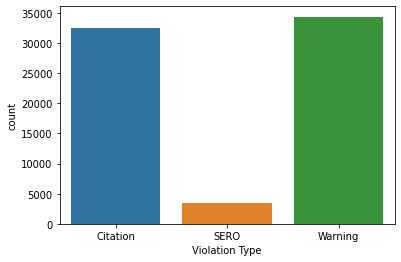

In [ ]:
sns.countplot(x='Violation Type', data=df)

In [ ]:
def clean_text(text):
  text = re.sub('\w*\d\w*', '', text)
  text= re.sub('\d', '', text)
  return text 

In [ ]:
Xtrain['Description']

0        'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...
1        'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...
2          'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE'
3        'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...
4        'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...
                               ...                        
70335         'PARKING WHERE PROHIBITED BY OFFICIAL SIGNS'
70336    'FAILURE TO DISPLAY REGISTRATION CARD UPON DEM...
70337    'DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REG...
70338         'EXCEEDING THE POSTED SPEED LIMIT OF 30 MPH'
70339    'OPERATING VEHICLE ON HIGHWAY WITH UNAUTHORIZE...
Name: Description, Length: 70340, dtype: object

In [ ]:
Xtrain['Description']= Xtrain['Description'].apply(lambda x: clean_text(x))
Xtrain['Description']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...
1        'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...
2          'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE'
3        'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...
4        'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...
                               ...                        
70335         'PARKING WHERE PROHIBITED BY OFFICIAL SIGNS'
70336    'FAILURE TO DISPLAY REGISTRATION CARD UPON DEM...
70337    'DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REG...
70338           'EXCEEDING THE POSTED SPEED LIMIT OF  MPH'
70339    'OPERATING VEHICLE ON HIGHWAY WITH UNAUTHORIZE...
Name: Description, Length: 70340, dtype: object

In [ ]:
def bow_feature_eng():
  bow=CountVectorizer(min_df=1, max_df=0.9, ngram_range=(1,2), 
                      analyzer='word', stop_words='english', 
                      max_features=5000)  #creating unigram and bigrams      
  bow.fit(Xtrain['Description'])                                               #fitting on training set
  return bow

In [ ]:
bow=bow_feature_eng()                                                       #feature extraction using bag-of-words
bow_features_train= bow.transform(Xtrain['Description'])
bow_features_train 

<70340x4720 sparse matrix of type '<class 'numpy.int64'>'
	with 870630 stored elements in Compressed Sparse Row format>

In [ ]:
bow.get_feature_names_out()

array(['abandoning', 'abandoning veh', 'abatement', ..., 'zone notice',
       'zone speed', 'zone veh'], dtype=object)

In [ ]:
Xtrain['Belts']= Xtrain['Belts'].map({'No':0, 'Yes':1}) 
Xtrain['Personal Injury']= Xtrain['Personal Injury'].map({'No':0, 'Yes':1}) 
Xtrain['Property Damage']= Xtrain['Property Damage'].map({'No':0, 'Yes':1}) 
Xtrain['Contributed To Accident']= Xtrain['Contributed To Accident'].map({'No':0, 'Yes':1}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
feat= np.asarray(bow_features_train)
bow_features_train.shape

(70340, 4720)

In [ ]:
belt= np.asarray(Xtrain['Belts']).reshape((-1, 1))
print(belt.shape)
pi= np.asarray(Xtrain['Personal Injury']).reshape((-1, 1))
pdam= np.asarray(Xtrain['Property Damage']).reshape((-1, 1))
cacc= np.asarray(Xtrain['Contributed To Accident']).reshape((-1, 1))

(70340, 1)


In [ ]:
features = np.asarray(bow_features_train.toarray())
features = np.append(features, pi, axis=1)
features = np.append(features, belt, axis=1)
features = np.append(features, pdam, axis=1)
features = np.append(features, cacc, axis=1)

In [ ]:
print(features.shape)

(70340, 4724)


In [ ]:
Ytrain= Ytrain.map({'Citation':0, 'SERO':1, 'Warning':2})

In [ ]:
yTrain_np = np.asarray(Ytrain)


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = [KNeighborsClassifier, RandomForestClassifier, LinearSVC]
sk_folder = StratifiedKFold(5)

for model in models:
    acc = []
    rec = []
    spec = []
    prec = []
    f_score = []
    for (idx, (train_index, test_index)) in enumerate(sk_folder.split(features, yTrain_np)):
        # Gets each fold
        X_train_folded, X_test_folded = features[train_index], features[test_index]
        y_train_folded, y_test_folded = yTrain_np[train_index], yTrain_np[test_index]
        print(f"Training fold {idx + 1} with {model.__name__}")
        my_model = model()
        my_model.fit(X_train_folded, y_train_folded)
        y_pred = my_model.predict(X_test_folded)
        acc.append(accuracy_score(y_test_folded, y_pred))
        rec.append(recall_score(y_test_folded, y_pred, average='macro'))
        prec.append(precision_score(y_test_folded, y_pred, average='macro'))
        f_score.append(f1_score(y_test_folded, y_pred, average='macro'))
        spec_inters = []
        for i in range(3):
            y_copy = y_pred.copy()
            y_real_copy = y_test_folded.copy()
            for j in range(3):
                # 1 is for negatives and 0 is for positive, because we're interested in calculating for negatives
                y_copy[y_copy == j] = 1 if j != i else 0
                y_real_copy[y_real_copy == j] = 1 if j != i else 0
            tn = np.count_nonzero(y_copy * y_real_copy)
            n = np.count_nonzero(y_test_folded)
            spec_inters.append(tn / n)
        spec.append(np.mean(spec_inters))
    print(model.__name__, {
        "Accurracy": np.mean(acc),
        "Sensitivity & Recall": np.mean(rec),
        "Specificity": np.mean(spec),
        "Precision": np.mean(prec),
        "F1": np.mean(f_score)
    })

Training fold 1 with KNeighborsClassifier
Training fold 2 with KNeighborsClassifier
Training fold 3 with KNeighborsClassifier
Training fold 4 with KNeighborsClassifier
Training fold 5 with KNeighborsClassifier
KNeighborsClassifier {'\n Accurracy': 0.7458913847028719, '\n Sensitivity & Recall': 0.8216863318089874, '\n Specificity': 0.7148021290093013, '\n Precision': 0.8081078557713827, '\n F1': 0.8126865268396972}
Training fold 1 with RandomForestClassifier
Training fold 2 with RandomForestClassifier
Training fold 3 with RandomForestClassifier
Training fold 4 with RandomForestClassifier
Training fold 5 with RandomForestClassifier
RandomForestClassifier {'\n Accurracy': 0.7937304520898493, '\n Sensitivity & Recall': 0.8523749709259498, '\n Specificity': 0.7953794130415026, '\n Precision': 0.8661567746081174, '\n F1': 0.851541023251879}
Training fold 1 with LinearSVC
Training fold 2 with LinearSVC
Training fold 3 with LinearSVC
Training fold 4 with LinearSVC
Training fold 5 with LinearSV

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC {'\n Accurracy': 0.793104918965027, '\n Sensitivity & Recall': 0.8523199328016775, '\n Specificity': 0.7955289467127549, '\n Precision': 0.8649310325263082, '\n F1': 0.8506000253715131}
